In [1]:
import math
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
""" data analysis with chi-square goodness of fit"""

def obs_cts(n, data):
    """ given: the data and number of bins
        returns: the observed values and the bin edges as lists"""
    events, edges = np.histogram(data, n)
    return events.tolist() , edges.tolist()

def exp_cts(n, data):
    """ given: the data and number of bins
        returns: the expected values and prob over each of the bins with
        the necessary modification of the first and last bins"""
    L=[]
    P_bins =[]
    for x in obs_cts(n,data)[1]:
        L.append(rv.cdf(x))
    P_bins.append(L[1])    
    for i in range(1,len(L)-2):
        P_bins.append(L[i+1]-L[i])    
    P_bins.append(1-L[-2])
    exp_cnt = [x * len(data) for x in P_bins]
    return exp_cnt, P_bins

def ind_bins_to_reduce(f_exp):
    """ given: a list
        returns: the indexes of the elements < 5"""
    NC_to_red =[index for index,value in enumerate(f_exp) if value < 5]
    return NC_to_red

def one_reduce(f_exp, f_obs, f_edge):
    """ given: lists of exp, obs, edges
        returns: new lists with one reduced bin with value < 5 """
    BTR = ind_bins_to_reduce(f_exp)
  
    if (len(BTR)>1 or (len(BTR)==1 and BTR[0]!=0)):
        f_exp[BTR[-1]-1] = f_exp[BTR[-1]-1]+f_exp[BTR[-1]]
        f_obs[BTR[-1]-1] = f_obs[BTR[-1]-1]+f_obs[BTR[-1]]
        del(f_edge[BTR[-1]])
        del(f_obs[BTR[-1]])
        del(f_exp[BTR[-1]])
    else:
        if BTR[0]==0:
            f_exp[1]= f_exp[1]+f_exp[0]
            f_obs[1]= f_obs[1]+f_obs[0]
            del(f_edge[1])
            del(f_obs[0])
            del(f_exp[0])

    f_expN = f_exp
    f_obsN = f_obs
    f_edgeN = f_edge
    BTRN = ind_bins_to_reduce(f_expN)
    return f_expN, f_obsN, f_edgeN, BTRN

def all_reduce(f_expF, f_obsF, f_edgeF, BTRF):
    """ finalizes the bin reduction """
    while BTRF !=[]:
        u = one_reduce(f_expF, f_obsF, f_edgeF)
        f_expF = u[0]
        f_obsF = u[1]
        f_edgeF = u[2]
        BTRF = u[3]
    return f_expF, f_obsF, f_edgeF, BTRF


def model(data, n, dof):
        """ given data, the number of bins (n) and the number of estimated parameters (dof)
        produces the value of the chi-squate test statistics and the p-value"""

        ## final expected count and final observed count after amalgamating bins
        exp, obs = all_reduce(exp_cts(n, data)[0],obs_cts(n, data)[0],
                obs_cts(n, data)[1], ind_bins_to_reduce(exp_cts(n, data)[0]))[0:2] 
        # build in chi-gof test, the last argument is the adjustment to the dof
        result = ss.chisquare( np.asarray(obs), np.asarray(exp), dof) 
        return result 

In [3]:
def skipHeader(dataFile):
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    
def readData(periods):
    for i in range(1,11):
        f = open('./Data/results' + str(i) + '.txt', 'r')
        skipHeader(f) #Skips the four header lines at the time of the file.

        arrivals = [] # Array of arrivals for a period of time
        departures = [] # Array of departures for a period of time
        startTime = float(f.readline()[0:-1].split('  ')[0])
        endTime = None

        for line in f:
            observation = line[0:-1].split('  ')
            if observation[1] == 'a':
                arrivals.append(float(observation[0]))
            elif observation[1] == 'd':
                departures.append(float(observation[0]))
            else:
                endTime = float(observation[0])

        periods.append([startTime, arrivals, departures, endTime])

In [4]:
periods = [] # Array containing periods of format [start time, arrivals, departures, end time]
readData(periods)

interArrivalTimes = []
for p in periods:
    for a in range(1, len(p[1])):
        interArrivalTimes.append(p[1][a] - p[1][a - 1])        
interArrivalBins = int(round(1 + np.log2(len(interArrivalTimes))))

#serviceTimes = []
#for p in periods:
#    for d in range(1, len(p[2])):
#        serviceTimes.append(p[2][d] - p[2][d - 1])
#serviceBins = int(round(1 + np.log2(len(serviceTimes))))

serviceTimes = []
for p in periods:
    serviceTimes.append(p[2][0]-p[1][0])
    for i in range(1,len(p[2])):
        if(p[2][i - 1] > p[1][i]):
            serviceTimes.append(p[2][i] - p[2][i - 1])
        else:
            serviceTimes.append(p[2][i] - p[1][i])
serviceBins = int(round(1 + np.log2(len(serviceTimes))))
print(np.mean(serviceTimes))

42.50126948591549


mean = 58.28008368978102


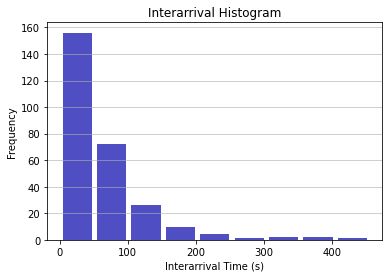

In [5]:
#Interarrival Histogram
plt.hist(x=interArrivalTimes, bins=interArrivalBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interarrival Time (s)')
plt.ylabel('Frequency')
plt.title('Interarrival Histogram')
plt.plot();
print("mean =",np.mean(interArrivalTimes))

In [6]:
print("interarival times:\n")
print(interArrivalTimes)

interarival times:

[1.2090000000025611, 0.8850000000020373, 15.328999999997905, 1.0169999999998254, 5.889999999999418, 18.48800000000483, 30.638999999995576, 30.97400000000198, 18.641999999999825, 38.70599999999831, 68.12200000000303, 31.401999999994587, 3.302000000003318, 17.411999999996624, 152.93700000000536, 66.86099999999715, 1.5020000000004075, 151.05299999999988, 4.423999999999069, 206.9250000000029, 80.26900000000023, 12.091999999996915, 83.49399999999878, 1.831000000005588, 79.47899999999936, 10.328000000001339, 106.64099999999598, 41.10599999999977, 34.74399999999878, 34.457000000002154, 37.83400000000256, 182.21199999999953, 153.38899999999558, 0.7380000000048312, 6.718000000000757, 43.55999999999767, 9.60899999999674, 73.38999999999942, 23.664000000004307, 46.36099999999715, 80.14199999999983, 23.855999999999767, 12.072000000000116, 83.88700000000244, 124.59300000000076, 93.86699999999837, 16.40099999999802, 6.586000000002969, 47.667999999997846, 95.16799999999785, 52.3680

mean = 42.50126948591549


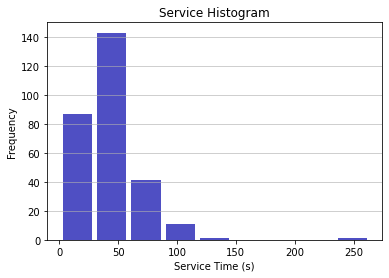

In [7]:
#Service Histogram
plt.hist(x=serviceTimes, bins=serviceBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Service Time (s)')
plt.ylabel('Frequency')
plt.title('Service Histogram')
plt.plot();
print("mean =",np.mean(serviceTimes))

In [8]:
print("Service Times:\n")
print(serviceTimes)

Service Times:

[43.27100000000064, 0.5010000000038417, 33.02300000000105, 17.610000000000582, 37.40199999999459, 1.3780000000042492, 27.06199999999808, 20.046000000002095, 89.47200000000157, 9.665999999997439, 52.87399999999616, 24.419000000001688, 37.074000000000524, 33.508999999998196, 39.21399999999994, 47.40600000000268, 23.432999999997264, 39.39400000000023, 34.62200000000303, 33.73199999999633, 82.05399999999645, 53.00900000000547, 30.312999999994645, 61.96800000000076, 35.961999999999534, 74.98800000000483, 41.09799999999814, 65.21499999999651, 43.19600000000355, 2.186999999998079, 70.65499999999884, 95.77300000000105, 73.99799999999959, 56.671000000002095, 2.15400000000227, 17.854999999995925, 55.408000000003085, 70.10299999999552, 42.75600000000122, 42.69800000000396, 4.021999999997206, 42.9800000000032, 12.661999999996624, 59.59200000000419, 55.46899999999732, 47.6449999999968, 32.70999999999913, 29.25800000000163, 40.177999999999884, 41.36899999999878, 88.24000000000524, 28

In [9]:
#Goodness of fit for interarrival data with exponential distribution

#parameter estimation 
params=ss.expon.fit(interArrivalTimes, floc=0)
print(params)
rv = ss.expon(params[0],params[1])
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 1

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))
##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

(0.0, 58.28008368978102)
The chi_sq test value is   1.198479 and the p-value is   0.753369


In [4]:
#interArrivalTimes
myHist = plt.hist(interArrivalTimes, int(round(1 + np.log2(len(interArrivalTimes)))), normed=True)
x = np.linspace(0.001,500) 
h = plt.plot(x, rv.pdf(x), lw=2)

NameError: name 'plt' is not defined

In [11]:
#Goodness of fit for interarrival data with gamma distribution

#parameter estimation 
params=ss.gamma.fit(interArrivalTimes, floc=0)
print(params)
rv = ss.gamma(params[0],params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

(0.7631101276483833, 0, 76.37178642796708)
The chi_sq test value is   5.599012 and the p-value is   0.132835


In [12]:
#Goodness of fit for interarrival data with erlang distribution

#parameter estimation 
params=ss.erlang.fit(interArrivalTimes, floc=0)
print(params)

rv = ss.erlang(round(params[0]),params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(interArrivalTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(interArrivalTimes, n, dof)[0], model(interArrivalTimes,n,dof)[1]))

(0.7631101276483833, 0, 76.37178642796708)
The chi_sq test value is  16.188230 and the p-value is   0.001038


In [13]:
#Goodness of fit for service data with exponential distribution

#parameter estimation 
params=ss.expon.fit(serviceTimes, floc=0)
print(params)
rv = ss.expon(params[0],params[1])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 1

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))
##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

(0.0, 42.50126948591549)
The chi_sq test value is 115.106254 and the p-value is   0.000000


In [14]:
#Goodness of fit for service data with gamma distribution

#parameter estimation 
params=ss.gamma.fit(serviceTimes, floc=0)
print(params)
rv = ss.gamma(params[0],params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))

##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

(2.76135310883745, 0, 15.391464912580066)
The chi_sq test value is   8.713053 and the p-value is   0.003159


In [15]:
#Goodness of fit for service data with erlang distribution

#parameter estimation 
params=ss.erlang.fit(serviceTimes, floc=0)
print(params)

rv = ss.erlang(round(params[0]),params[1],params[2])
    
# set the adjustment to dof (degree of freedom) = to the number of parameters estimated
dof = 2

# chose the number of bins
n=int(round(1 + np.log2(len(serviceTimes))))
print(params[1])
##  experiment--------------------------------------------------
    
print ("The chi_sq test value is %10.6f and the p-value is %10.6f" % 
       (model(serviceTimes, n, dof)[0], model(serviceTimes,n,dof)[1]))

(2.76135310883745, 0, 15.391464912580066)
0
The chi_sq test value is  10.054705 and the p-value is   0.006556


AttributeError: 'Rectangle' object has no property 'normed'

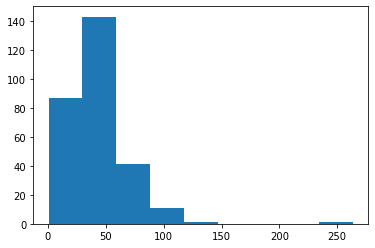

In [19]:
myHist = plt.hist(serviceTimes, int(round(1 + np.log2(len(serviceTimes)))), normed=True)
x = np.linspace(0.001,500) 
h = plt.plot(x, rv.pdf(x), lw=2)

In [17]:
#Observed W
allW = []
for p in periods:
    wTimes = []
    for d in range(1, len(p[2])):
        wTimes.append(p[2][d] - p[1][d])
    allW.append(np.mean(wTimes))


arrivalrate = 1/(np.mean(interArrivalTimes))
servicerate = 1/(np.mean(serviceTimes))
intensity = arrivalrate/servicerate

#Estimated Arrival Rate
print("Estimated arrival rate:",arrivalrate)
print("Estimated service rate:",servicerate)
print("Estimated W:",np.mean(allW))
print("Estimated Ws:",np.mean(serviceTimes))

print("")
print("Estimated traffic intensity:",arrivalrate/servicerate)

#Observed L
allL = []



#Average customers per period (NOT L)
arrN = []
for p in periods:
    arrN.append(len(p[2]))
    
print("\nAverage customers per period:",np.mean(arrN))

Estimated arrival rate: 0.01715852031584063
Estimated service rate: 0.023528708956126364
Estimated W: 101.97299506516548
Estimated Ws: 42.50126948591549

Estimated traffic intensity: 0.7292588959230984

Average customers per period: 28.4
